In [1]:
from pickletools import optimize
import torch, torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import os
from skimage import io, transform

from model import *
from utils import predict_transform, bbox_iou
from dataset import filter_labels, bbox_anchorbox_iou, draw_bbox, centre_dims_to_corners, DetectionDataset, Rescale, ToTensor, Normalise

plt.rcParams['figure.figsize'] = [15,15]

## Rejig Custom Dataset

**Objective:** We want each label to be [x, y, w, h, obj?, c_1, c_2, ..., c_n]

## Check Custom Dataset without Transforms

In [2]:
# Call custom dataset
# set desired parameters
train_data = DetectionDataset(
    label_dict="det_train_shortened.json",
    root_dir="images/",
    classes_file="data/bdd100k.names",
    grid_sizes=[13, 26, 52],
    anchors = np.array([
            [[116,90], [156,198], [373,326]],
            [[30, 61], [62, 45], [59,119]],
            [[10, 13], [16, 30], [33, 23]],
        ])
)

# separate into batches
train_loader = DataLoader(
    train_data,
    batch_size=1,
    shuffle=True,
    num_workers=0
)

### Example label for an image

In [3]:
train_data[0]["labels"].shape

(10647, 17)

### Example label after being batched

In [49]:
for i, data in enumerate(train_loader):
    image, labels = data.values()
labels.shape

torch.Size([1, 10647, 17])

### Example single object label from image

In [44]:
batch_i = 1 # <-- change batch idx

ex_img_data = train_data[batch_i] 
idx, _ = np.nonzero(ex_img_data["labels"])
rand_idx = np.random.choice(idx, 1)[0]
ex_obj_label = ex_img_data["labels"][rand_idx]
ex_obj_label

array([568.8365665, 336.2419845,   9.793455 ,  24.483639 ,   1.       ,
         0.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         1.       ,   0.       ,   0.       ,   0.       ,   0.       ,
         0.       ,   0.       ])

-------Bbox corner coords-------
[563.939839 324.000165 573.733294 348.483804]
-----------Bbox class-----------
pedestrian
---------Bbox on image----------


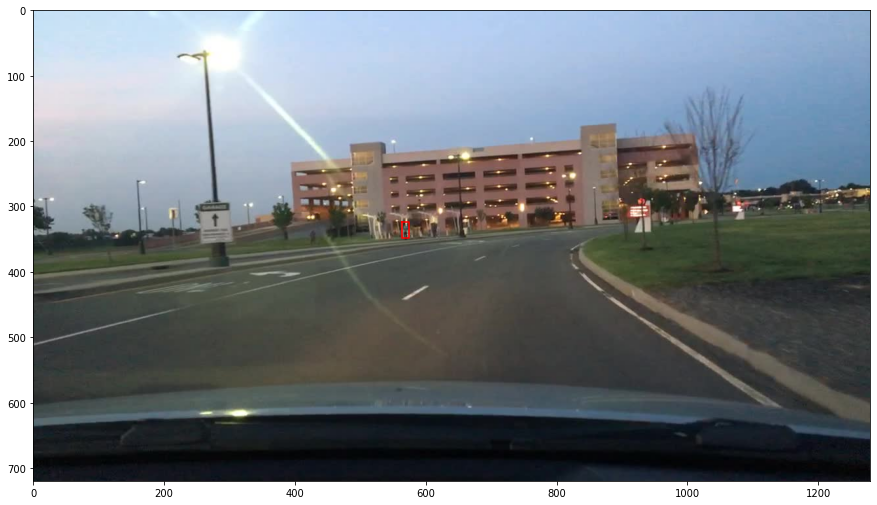

In [45]:
ex_img = ex_img_data["image"]
bbox_corners = centre_dims_to_corners(ex_obj_label[:4])
print("-------Bbox corner coords-------")
print(bbox_corners)
print("-----------Bbox class-----------")
print(load_classes("data/bdd100k.names")[np.argmax(ex_obj_label[-12:])])
print("---------Bbox on image----------")
draw_bbox(ex_img, [bbox_corners])

### Example of output prediction from final yolo detection layer

In [46]:
all_det_preds = torch.load("ex_tensors/yolo_layer_output_size10647.pt")
all_det_preds.shape

torch.Size([1, 10647, 85])

In [48]:
labels.shape

torch.Size([1, 10647, 17])

## Anchors in labels

Find which anchorbox has the largest IoU with bbox label

In [2]:
def corners_to_centre_dims(bbox):
    width = bbox[2]-bbox[0]
    height = bbox[3]-bbox[1]
    x_centre = bbox[0]+(width/2)
    y_centre = bbox[1]+(height/2)
    new_bbox = np.array([x_centre, y_centre, width, height])
    return new_bbox

def centre_dims_to_corners(bbox):
    """
    Converts bbox attributes of form [x_centre, y_centre, width, height] to form [x1, y1, x2, y2]. 
    
    This form is used for easily calculating 2 bbox's IoU.
    """
    x_c, y_c, w, h = bbox[:,0], bbox[:,1], bbox[:,2], bbox[:,3]
    x1, x2 = x_c-(w/2), x_c+(w/2)
    y1, y2 = y_c-(h/2), y_c+(h/2)
    
    x1 = np.expand_dims(x1, 1)
    x2 = np.expand_dims(x2, 1)
    y1 = np.expand_dims(y1, 1)
    y2 = np.expand_dims(y2, 1)

    new_bbox = np.concatenate((x1, y1, x2, y2), axis=1)
    return new_bbox

In [21]:
grid_size = 13
classes = np.array(load_classes("data/bdd100k.names"))
n_classes = len(classes)
anchors = np.array([
    [[116,90], [156,198], [373,326]],
    [[30, 61], [62, 45], [59,119]],
    [[10, 13], [16, 30], [33, 23]],
])
n_anchors = anchors.shape[1]

grid = np.arange(1, grid_size+1)
a,b = np.meshgrid(grid,grid)

#path = "C:/Users/henry/Github/Projects/panoptic_perception_network/"
img = plt.imread("images/0000f77c-6257be58.jpg")
stride_x = ((img.shape[0])//(grid_size))
stride_y = ((img.shape[1])//(grid_size))

a *= stride_x 
b *= stride_y 
a = a - stride_x/2
b = b - stride_y/2

In [4]:
bbox = np.array([49.44476737704903, 254.530367, 357.805838, 487.906215])
category = classes[2]
width = bbox[2]-bbox[0]
height = bbox[3]-bbox[1]
x_centre = bbox[0]+(width/2)
y_centre = bbox[1]+(height/2)
new = np.array([x_centre, y_centre, width, height])
new

array([203.62530269, 371.218291  , 308.36107062, 233.375848  ])

In [5]:
grid_coords = np.concatenate((b.reshape(-1,1), a.reshape(-1,1)), axis=1)
dists = np.sum(np.square(grid_coords-new[:2]), axis=1).reshape(13,13)

In [6]:
# find coord of grid cell that bbox centre belong to
w_idx, h_idx = np.unravel_index(dists.argmin(), dists.shape)

In [7]:
# make class type label
class_array = (classes == category).astype(int)
class_array

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
obj_cell_label = np.concatenate((new, np.array([1]), class_array))

In [74]:
np.tile(new[:2], [3,1])

array([[203.62530269, 371.218291  ],
       [203.62530269, 371.218291  ],
       [203.62530269, 371.218291  ]])

In [11]:
bbox_tile = np.tile(new[:2], [3,1])
anchor_boxes = np.concatenate((bbox_tile, anchors[0]), 1)
anchor_boxes = centre_dims_to_corners(anchor_boxes)
anchor_boxes

array([[145.62530269, 326.218291  , 261.62530269, 416.218291  ],
       [125.62530269, 272.218291  , 281.62530269, 470.218291  ],
       [ 17.12530269, 208.218291  , 390.12530269, 534.218291  ]])

In [12]:
bbox

array([ 49.44476738, 254.530367  , 357.805838  , 487.906215  ])

In [14]:
anchorbox_ious = bbox_anchorbox_iou(bbox, anchor_boxes)
anchorbox_idx = np.argmax(anchorbox_ious)
anchorbox_idx

2

## Label cont.

In [ ]:
# all_labels should be an array of size (grid_size x grid_size x n_anchors, 5+n_classes)
# so if cell [0][0] in image grid includes the centre of a bbox with IoU largest with anchor box 2
#   the bbox attr row should be slotted into all_labels[001] 

In [58]:
# init image label
labels = np.zeros(shape=(grid_size, grid_size, n_anchors, 5+n_classes))
labels[w_idx][h_idx][anchorbox_idx] = obj_cell_label # (2,6)
labels = labels.reshape(-1, 5+n_classes)
# label is now stored at idx (w_idx*grid_size + h_idx)*n_anchors + anchorbox_idx

In [59]:
#np.argmax(np.sum(labels, axis=1))
labels[(w_idx*grid_size + h_idx)*n_anchors + anchorbox_idx]

array([203.62530269, 371.218291  , 308.36107062, 233.375848  ,
         1.        ,   0.        ,   0.        ,   1.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ])

In [60]:
labels.shape

(507, 17)

In [68]:
another_label = np.zeros(shape=(26*26*3, 17))
another_label.shape

(2028, 17)

In [72]:
np.concatenate((labels, another_label))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Load Dataset

### Testing manual pad transform

In [4]:
class Pad(object):
    """
    Add padding to image

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple)) # make sure output size is EITHER int or tuple
        self.output_size = output_size

    def __call__(self, sample):
        image, categories, bboxes = sample["image"], sample["categories"], sample["bboxes"]

        img_w, img_h = image.shape[1], image.shape[0]
        w, h = self.output_size

        # calculate new width and height
        new_w = int(img_w * min(w/img_w, h/img_h))
        new_h = int(img_h * min(w/img_w, h/img_h))
        resized_image = cv2.resize(image, (new_w,new_h), interpolation = cv2.INTER_CUBIC)
        
        canvas = np.full((self.output_size[1], self.output_size[0], 3), 128)

        canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image

        return {"image": canvas, "categories": categories, "bboxes": bboxes}

In [5]:
filtered_labels = filter_labels("det_train_shortened.json")

train_data = DetectionDataset(
    label_dict=filtered_labels,
    root_dir='images/',
)
## load custom dataset + transforms
transformed_train_data = DetectionDataset(
    label_dict=filtered_labels,
    root_dir='images/',
    transform=transforms.Compose([
        Rescale(608),
        Normalise(0.5, 0.5),
        Pad((608,608)),
        ToTensor()
    ])
)

## dataloader
train_loader = DataLoader(
    transformed_train_data,
    batch_size=1,
    shuffle=True,
    num_workers=0
)

## Conv -> Detection (Predict Transform)

In [6]:
blocks = parse_cfg('./cfg/model.cfg')
net_info, module_list = create_modules(blocks)

In [7]:
modules = blocks[1:]

In [8]:
anchors = module_list[-1][0].anchors
anchors

[(10, 13), (16, 30), (33, 23)]

In [9]:
in_dims = int(net_info["height"])
in_dims

608

In [10]:
n_classes = int(modules[-1]["classes"], in_dims, anchors, 80)
n_classes

80

In [14]:
prediction = torch.load("ex_tensors/yolo_layer_input.pt")
predict_transform(prediction, )

torch.Size([1, 255, 52, 52])

507 = size of first det output (yolo_layer_output_size507.pt)

In [71]:
print("Det 1 grid size:")
print(np.sqrt(507/3))
print("Det 2 grid size:")
print(np.sqrt((2535-507)/3))
print("Det 3 grid size:")
print(np.sqrt((10647-2535)/3))

Det 1 grid size:
13.0
Det 2 grid size:
26.0
Det 3 grid size:
52.0


## Define Network

In [53]:
net = Net(cfgfile="cfg/model.cfg")

In [7]:
class TestNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)     # in 1 , out 6, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5)    # in 6, out 16, 5x5 kernel

        self.pool = nn.MaxPool2d(2, 2)      # this time define own maxpooling
        
        # an affine op: y = Wx + b
        self.fc1 = nn.Linear(16*5*5, 120)   # 5x5 is image dim
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # max pooling over a (2,2) window
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dims except batch dim
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # no activation on final layer -> output
        return x
testnet = TestNet()

## Define Loss Function and Optimiser

In [7]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = ...

## Train Network

In [ ]:
CUDA = torch.cuda.is_available()
for i, data in enumerate(train_loader):
    input_img, cat, bboxes = data.values()

    optimizer.zero_grad()
    #plt.imshow(input_img)
    #input_img = norm_with_padding(input_img, 608)
    outputs = net(Variable(input_img.float()), CUDA)
    

In [10]:
outputs[...,0] # select first bbox attr from all bbox tensors

tensor([[ 16.8364,  15.2165,  15.7572,  ..., 605.3627, 603.0162, 604.4326]])

## Troubleshooting bboxes

In [96]:
outputs = torch.load("1.pt")

In [97]:
outputs = outputs*(outputs[:,:,4] > 0.5).float().unsqueeze(2)

In [98]:
outputs.shape

torch.Size([1, 10647, 85])

In [2]:
10647/3

3549.0

In [99]:
box_corner = outputs.new(outputs.shape)
box_corner[:,:,0] = (outputs[:,:,0] - outputs[:,:,2]/2)
box_corner[:,:,1] = (outputs[:,:,1] - outputs[:,:,3]/2)
box_corner[:,:,2] = (outputs[:,:,0] + outputs[:,:,2]/2)
box_corner[:,:,3] = (outputs[:,:,1] + outputs[:,:,3]/2)
# replace in the prediction tensor
outputs[:,:,:4] = box_corner[:,:,:4]

In [100]:
image_pred = outputs[0] # for each image in batch

In [101]:
image_pred.shape

torch.Size([10647, 85])

In [102]:
image_pred[:,5:5+80].shape

torch.Size([10647, 80])

In [103]:
torch.max(torch.tensor([1, 2, 3, 4, 5]), 0)

torch.return_types.max(
values=tensor(5),
indices=tensor(4))

In [104]:
max_conf, max_conf_idx = torch.max(image_pred[:,5:5+80], 1)

In [105]:
max_conf.shape

torch.Size([10647])

In [106]:
max_conf = max_conf.float().unsqueeze(1) # max_conf (1, 1, 85)
max_conf_score = max_conf_idx.float().unsqueeze(1) # max_conf_score (1, 1, 85)

In [107]:
image_pred[:,:5].shape

torch.Size([10647, 5])

In [108]:
max_conf.shape

torch.Size([10647, 1])

In [109]:
max_conf_score.shape

torch.Size([10647, 1])

In [110]:
seq = (image_pred[:,:5], max_conf, max_conf_score)
image_pred = torch.cat(seq, 1)
image_pred.shape

torch.Size([10647, 7])

In [111]:
image_pred[:,4]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [112]:
non_zero_idx = (torch.nonzero(image_pred[:, 4]))

In [113]:
non_zero_idx.shape

torch.Size([1, 1])

In [114]:
image_pred_ = image_pred[non_zero_idx.squeeze(), :].view(-1,7)

In [115]:
image_pred_

tensor([[-17.8275, 275.9133, 422.6099, 319.4225,   0.9276,   0.9997,   2.0000]])

In [122]:
conf_sort_idx = torch.sort(image_pred_[:,4], descending=True)[1]
image_pred_ordered = image_pred_[conf_sort_idx]

In [123]:
nms_conf = 0.4

conf_sort_idx = torch.sort(image_pred_[:,4], descending=True)[1]
image_pred_ordered = image_pred_[conf_sort_idx]

n_dets = image_pred_ordered.shape[0]
for idx in range(n_dets):
    # print(idx)
    # print(pred)
    try:
        ious = bbox_iou(image_pred_ordered[idx].unsqueeze(0), image_pred_ordered[idx+1:])
    except ValueError:
        break

    except IndexError:
        break

    iou_mask = (ious < nms_conf).float().unsqueeze(1)
    image_pred_ordered[idx+1:] *= iou_mask

    non_zero_idx = torch.nonzero(image_pred_ordered[:,4]).squeeze()
    image_pred_ordered = image_pred_ordered[non_zero_idx].view(-1,7)
    # print(image_pred_ordered)
    # print(image_pred_ordered.shape)

In [124]:
image_pred_ordered

tensor([[-17.8275, 275.9133, 422.6099, 319.4225,   0.9276,   0.9997,   2.0000]])

In [125]:
batch_idx = image_pred_ordered.new(image_pred_ordered.size(0), 1).fill_(idx)
batch_idx

tensor([[0.]])

In [ ]:
seq = batch_idx, image_pred_ordered
output = torch.cat(seq,1)
output

tensor([[  5.0000, 160.9702, 157.9619, 292.7193, 235.9922,   0.9994,   0.9109,
           2.0000],
        [  5.0000,  19.1932, 172.2979, 118.8749, 245.4051,   0.9974,   0.9965,
           2.0000],
        [  5.0000, -27.2960, 272.9604, 435.2546, 322.3747,   0.9865,   1.0000,
           2.0000],
        [  5.0000, 364.7225, 136.0251, 377.4218, 160.3831,   0.8234,   0.9997,
           9.0000],
        [  5.0000, 374.9868, 135.9671, 390.3168, 160.1495,   0.5790,   0.9998,
           9.0000]])